In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import datetime

%load_ext autoreload
%autoreload 2
    
import ml_utils.road_seg as rs
import ml_utils.model as model

Load raw images and ground truth

In [2]:
path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'

if not os.path.exists(path_models):
    os.mkdir(path_models)
train_imgs, train_gt, val_imgs, val_gt, id_train, id_valid = rs.load_train_set(path_train_dir, ratio=0.8)

Generate smaller images for training

In [3]:
patch_size = 80
patch_tr, lab_tr,_ = rs.get_patches_all(train_imgs, train_gt, patch_size)
patch_val, lab_val,_ = rs.get_patches_all(val_imgs, val_gt, patch_size)

print('Shapes train: {},  test: {}'.format(patch_tr.shape, patch_val.shape))

Shapes train: (2000, 80, 80, 3),  test: (500, 80, 80, 3)


Take only part of train and validation set (should at least contain a part of the road)

In [4]:
useful_patches_tr, useful_lab_tr = rs.get_useful_patches(patch_tr, lab_tr, 0.2, 0.7)
useful_patches_val, useful_lab_val = rs.get_useful_patches(patch_val, lab_val, 0.2, 0.7)
useful_lab_tr = useful_lab_tr.astype(int)
useful_lab_val = useful_lab_val.astype(int)

print('Shapes train: {},  test: {}'.format(useful_patches_tr.shape, useful_patches_val.shape))

Shapes train: (788, 80, 80, 3),  test: (214, 80, 80, 3)


Display patches example with label ground truth

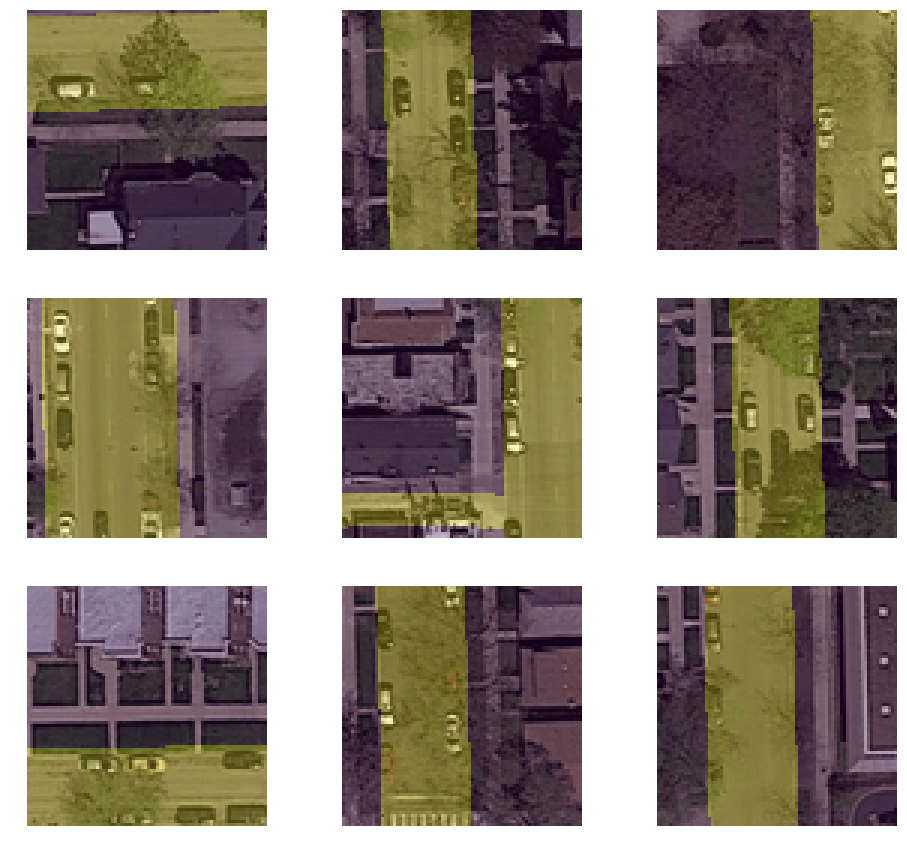

In [5]:
n_display = 9
id_display = np.random.permutation(len(useful_patches_tr))[:n_display]

plt.figure(figsize=(16, 5*(n_display//3)))
for i, id_ in enumerate(id_display):
    plt.subplot(n_display//3,3,i+1)
    plt.imshow(useful_patches_tr[id_]); plt.imshow(useful_lab_tr[id_], alpha=0.3); plt.axis('off');

In [22]:
import ml_utils.model as model

m = model.Model()
m.train_model(useful_patches_tr, useful_lab_tr, train_imgs, train_gt, val_imgs, val_gt, n_epoch=5)

conv1 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2 size (?, ?, ?, 128)
pool2 size (?, ?, ?, 128)
conv3 size (?, ?, ?, 256)
pool3 size (?, ?, ?, 256)
conv4 size (?, ?, ?, 256)
pool4 size (?, ?, ?, 256)
deconv1 size (?, ?, ?, 256)
deconv2 size (?, ?, ?, 256)
deconv3 size (?, ?, ?, 128)
deconv4 size (?, ?, ?, 64)
score size (?, ?, ?, 2)
Recap epoch  1
	 last minibatch, cross entropy :  0.576704 reg term :  4.72054e-05
	 val_loss :  0.54106284678 , train_loss :  0.55310593918
	 val f1 :  0.445413640692 , train f1 :  0.448628442348
Recap epoch  2
	 last minibatch, cross entropy :  0.475195 reg term :  7.8757e-05
	 val_loss :  0.433237329125 , train_loss :  0.451711514965
	 val f1 :  0.721280214503 , train f1 :  0.697505335456
Recap epoch  3
	 last minibatch, cross entropy :  0.358018 reg term :  0.000122052
	 val_loss :  0.312674034387 , train_loss :  0.324268076569
	 val f1 :  0.783437355779 , train f1 :  0.766939277662
Recap epoch  4
	 last minibatch, cross entropy :  0.446435 reg te

In [24]:
m = model.Model()
y_pred_train = m.apply_model(train_imgs, 'model/2017_12_02_15h44_model.ckpt')
y_pred_valid = m.apply_model(val_imgs, 'model/2017_12_02_15h44_model.ckpt')

conv1 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2 size (?, ?, ?, 128)
pool2 size (?, ?, ?, 128)
conv3 size (?, ?, ?, 256)
pool3 size (?, ?, ?, 256)
conv4 size (?, ?, ?, 256)
pool4 size (?, ?, ?, 256)
deconv1 size (?, ?, ?, 256)
deconv2 size (?, ?, ?, 256)
deconv3 size (?, ?, ?, 128)
deconv4 size (?, ?, ?, 64)
score size (?, ?, ?, 2)
INFO:tensorflow:Restoring parameters from model/2017_12_02_15h44_model.ckpt
INFO:tensorflow:Restoring parameters from model/2017_12_02_15h44_model.ckpt


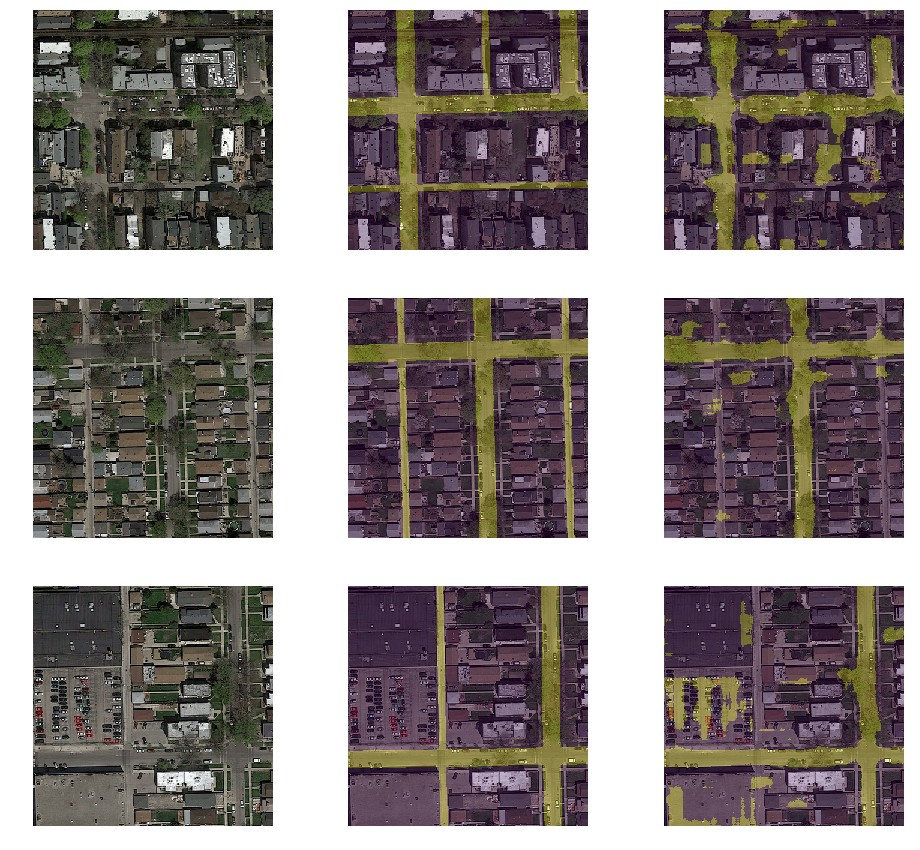

In [55]:
rs.display_predictions(y_pred_train, train_imgs, train_gt)

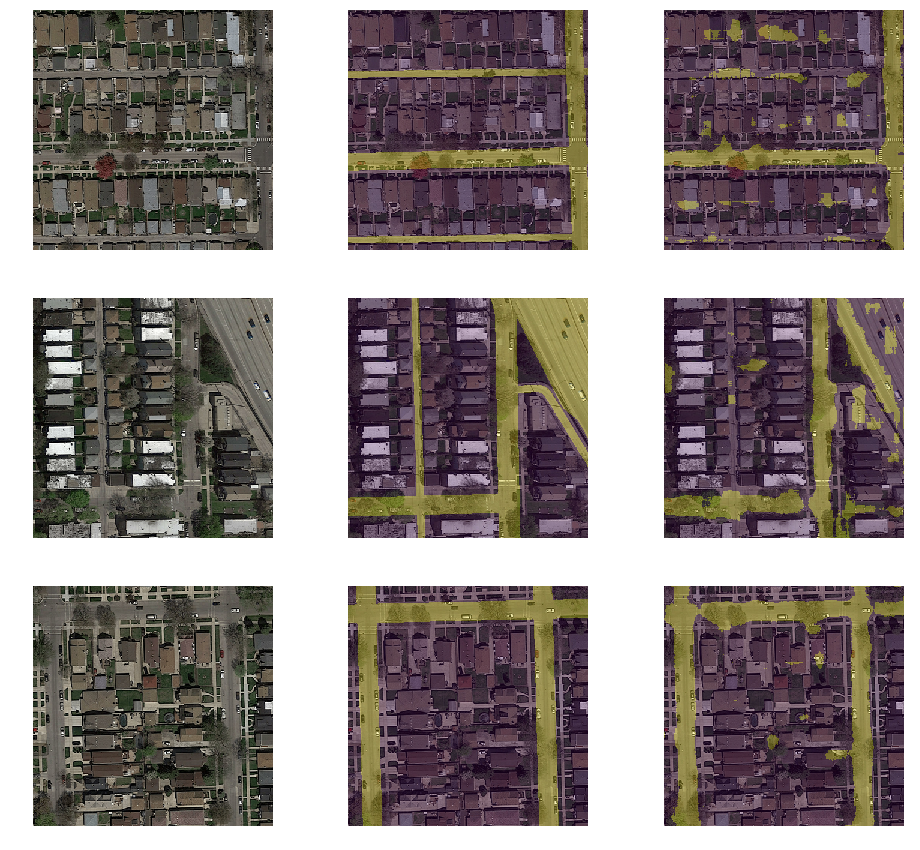

In [56]:
rs.display_predictions(y_pred_valid, val_imgs, val_gt)

In [71]:
test_img = rs.load_test_set(path_test)
y_pred_test = m.apply_model(test_img, 'model/2017_12_02_15h44_model.ckpt')
im_pred_test = np.reshape(y_pred_test, test_img.shape[:3]).astype(np.float32)

INFO:tensorflow:Restoring parameters from model/2017_12_02_15h44_model.ckpt


INFO:tensorflow:Restoring parameters from model/2017_12_02_15h44_model.ckpt


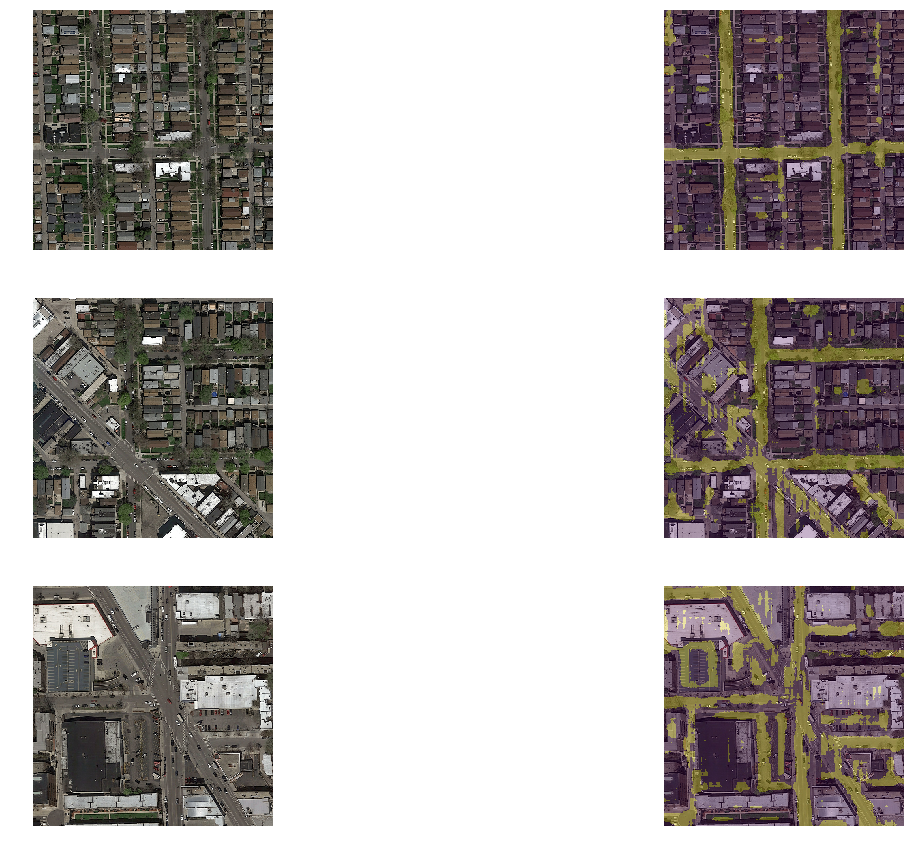

In [72]:
rs.display_predictions(y_pred_test, test_img)

In [78]:
rs.create_submission(im_pred_test, 'test_5epoch_classexample.csv')